In [18]:
import numpy as np
import matplotlib.pyplot as plt
from subprocess import call
from scipy.ndimage import gaussian_filter1d
import os
import pandas as pd
from math import isnan
import random
import glob
import sys
sys.path.append('../')
from package_global_functions import *

extSSDpath = getExternalSSDpath()
if os.path.exists(extSSDpath):
    resPath = extSSDpath + getProjectFoldername() + '/gillespie_sim_ci/results'
else:
    resPath = '/results'
    print('Forgot the SSD!!!!!')

### Make simulations with longer times for no ci??

In [19]:
pis, qs = [0.1, 0.1], [9.0, 10.0]
# pis, qs, lci = [0.2, 0.2], [9.0, 10.0], 1.0
N, ic, NreaStatData = 1000, 'N', 10000

lcis = [0.0, 1.0]
ci_kwargs = (0, )
ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])
cistr = str(ci_kwargs)

costFuncData = {}

# this is for pis 0.1 0.1, qs 9.0 10.0, lci 1.0
ls = [0.1, 0.15, 0.2, 0.3, 0.45, 0.6, 0.75, 0.9]
peaksCut_dic = {
    0.0: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    1.0: [0.0, 0.0, 0.0, 0.4, 0.4, 0.4, 0.4, 0.4],
}


pichain = '_'.join([str(pi) for pi in pis])
qchain = '_'.join([str(q) for q in qs])

winerProbData = pd.read_csv(f'{resPath}/winner_perc_data.csv')
winerProbData = winerProbData.query('pi1 == @pis[0] & pi2 == @pis[1] & q1 == @qs[0] & q2 == @qs[1] & ic == @ic & N == @N & ci_kwargs == @cistr') # & Nrea == @NreaStatData
for lci in lcis:
    costFuncData[lci] = {'f2winVal':[], 'f1loseVal':[], 'probf2winVal':[], 'tss':[], 'CF':[], 'f2winValerr':[], 'f1loseValerr':[], 'probf2winValerr':[], 'tsserr':[], 'CFerr':[]}
    for l,peaksCut in zip(ls,peaksCut_dic[lci]):
        tssDf = pd.read_csv(f'{resPath}/tss_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv')
        ssDataDf = pd.read_csv(f'{resPath}/ss_data_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv')
        # time to stationary state:
        tss, tsserr = np.average(tssDf['tssAvg']), np.std(tssDf['tssAvg'])/np.sqrt(len(tssDf['tssAvg']))
        costFuncData[lci]['tss'].append(tss), costFuncData[lci]['tsserr'].append(tsserr)
        # stationary value when f2 wins:
        f2winVal, f2winValerr = np.average(ssDataDf['f2'][ssDataDf['f2']>=peaksCut]), np.std(ssDataDf['f2'][ssDataDf['f2']>=peaksCut])/np.sqrt(len(ssDataDf['f2']))
        peaksCutf1 = peaksCut if peaksCut > 0.0 else (1-peaksCut)
        f1loseVal, f1loseValerr = np.average(ssDataDf['f1'][ssDataDf['f1']<peaksCutf1]), np.std(ssDataDf['f1'][ssDataDf['f1']<peaksCutf1])/np.sqrt(len(ssDataDf['f1']))
        costFuncData[lci]['f2winVal'].append(f2winVal), costFuncData[lci]['f2winValerr'].append(f2winValerr)
        costFuncData[lci]['f1loseVal'].append(f1loseVal), costFuncData[lci]['f1loseValerr'].append(f1loseValerr)
        ### probability to be in the f2 stationary point:
        if lci > 0.0:
            probf2win, NreaStatData = float(winerProbData.query('l == @l & lci == @lci')['f2win'].iloc[0]), float(winerProbData.query('l == @l & lci == @lci')['Nrea'].iloc[0])
            probf2winerr = np.sqrt(probf2win*(1-probf2win)/NreaStatData)
        else:
            probf2win, probf2winerr = 1.0, 0.0
        costFuncData[lci]['probf2winVal'].append(probf2win), costFuncData[lci]['probf2winValerr'].append(probf2winerr)
        # once having all the data compute the cost function value, and its std by error propagation:
        cf = probf2win*f2winVal/tss
        cferr = (1/tss)*np.sqrt((probf2win*f2winValerr)**2+(f2winVal*probf2winerr)**2+(f2winVal*probf2win*tsserr/tss)**2)
        costFuncData[lci]['CF'].append(cf), costFuncData[lci]['CFerr'].append(cferr)

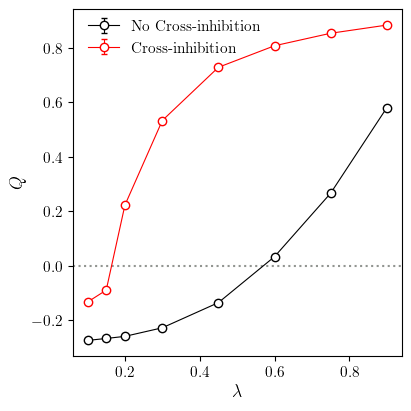

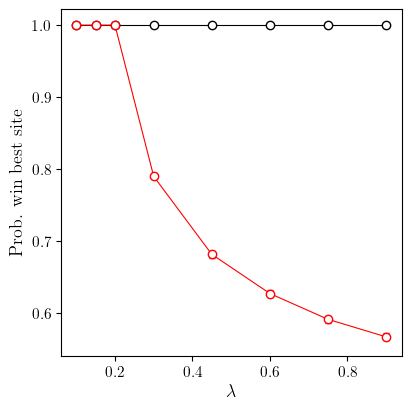

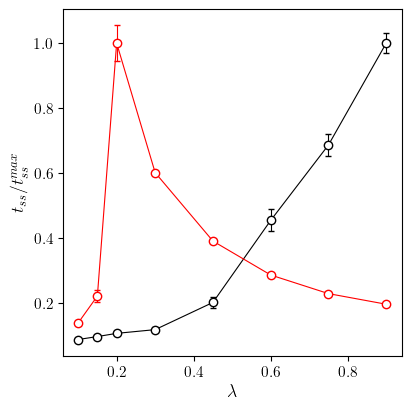

In [27]:
latexFont(ticklabelssize=11, labelsize=13, legendsize=11)
figQ, axQ = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)
figP, axP = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)
figT, axT = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)

axQ.set(xlabel='$\lambda$', ylabel='$Q$')
axP.set(xlabel='$\lambda$', ylabel='Prob. win best site')
axT.set(xlabel='$\lambda$', ylabel='$t_{ss}/t_{ss}^{max}$')

for lci,c in zip(lcis,['k', 'r']):
    cilabel = 'No Cross-inhibition' if lci==0.0 else 'Cross-inhibition'
    Q = np.array(costFuncData[lci]['f2winVal']) - 2*np.array(costFuncData[lci]['f1loseVal'])
    axQ.errorbar(ls, Q, costFuncData[lci]['f2winValerr'], lw=0.8, marker='o', color=c, mfc='w', label=cilabel, capsize=2.0)
    axP.errorbar(ls, costFuncData[lci]['probf2winVal'], costFuncData[lci]['probf2winValerr'], lw=0.8, marker='o', color=c, mfc='w', capsize=2.0)
    axT.errorbar(ls, costFuncData[lci]['tss']/max(costFuncData[lci]['tss']), costFuncData[lci]['tsserr']/max(costFuncData[lci]['tss']), lw=0.8, marker='o', color=c, mfc='w', capsize=2.0)

figQ.legend(frameon=False, loc=(0.2, 0.85))
axQ.axhline(0.0, 0, 1, ls=':', color='xkcd:gray')

figQ.savefig('no_ci_vs_ci_Q.pdf')
figP.savefig('no_ci_vs_ci_probBestWin.pdf')
figT.savefig('no_ci_vs_ci_time.pdf')